# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding (Pipeline Steps G-I)
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Dataset: QC'd TF KO (and NTC) dataset
-  Analysis: pseudobulk differential expression analysis (DEA), pairwise Pearson correlation matrix, minimum distortion embedding (MDE)
***

# Import statements and global random seed

In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gc
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import pickle as pkl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
from biothings_client import get_client
import decoupler as dc
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

# Set global random seed as safety measure for reproducibility
np.random.seed(92093)

# Filtering lowly expressed genes

Filter TF KO and NTC cells

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

def filter_tf_ko_and_ntc(adata):
    """
    Filter for TF KO and NTC cells.
    """
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
print(f"Total cells per batch: ALPHA {adata_alpha.shape[0]}, BETA {adata_beta.shape[0]}, GAMMA {adata_gamma.shape[0]}")

Total cells per batch: ALPHA 81583, BETA 75646, GAMMA 47542


In [4]:
adata_alpha_tf_ntc = filter_tf_ko_and_ntc(adata_alpha)
adata_beta_tf_ntc = filter_tf_ko_and_ntc(adata_beta)
adata_gamma_tf_ntc = filter_tf_ko_and_ntc(adata_gamma)
print(f"TF KO and NTC cells per batch: ALPHA {adata_alpha_tf_ntc.shape[0]}, "
      f"BETA {adata_beta_tf_ntc.shape[0]}, GAMMA {adata_gamma_tf_ntc.shape[0]}")

TF KO and NTC cells per batch: ALPHA 44248, BETA 12881, GAMMA 9310


Concatenate all 3 batches into 1 dataset

In [5]:
adata_tf_ntc = ad.concat([adata_alpha_tf_ntc, adata_beta_tf_ntc, adata_gamma_tf_ntc])
adata_tf_ntc

AnnData object with n_obs × n_vars = 66439 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [6]:
adata_tf_ntc.obs.perturbed.value_counts()

perturbed
False    35229
True     31210
Name: count, dtype: int64

Filter lowly expressed genes

In [7]:
def filter_low_expressed_genes(adata, percent_threshold=None, min_n_cells=None):
    """
    Filter out bottom percentile of genes with lowest expression (normalized and
    log1p-transformed) and/or genes expressed in fewer than min_n_cells cells.
    """
    n_genes_before = adata.shape[1]
    # Create histogram layer, normalize, and log-transform
    layer_to_copy = adata.layers["counts"] if "counts" in adata.layers else adata.X
    adata.layers["histogram"] = layer_to_copy.copy()
    sc.pp.normalize_total(adata, layer="histogram")
    sc.pp.log1p(adata, layer="histogram")
    data_matrix = adata.layers["histogram"]

    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()
    
    # Filter genes expressed in fewer than min_n_cells cells
    if min_n_cells:
        gene_detected_counts = (data_matrix > 0).sum(axis=0)
        genes_pass_cell_thr = gene_detected_counts >= min_n_cells
        data_matrix = data_matrix[:, genes_pass_cell_thr].copy()
        adata = adata[:,genes_pass_cell_thr].copy()

    # Filter bottom percentile of genes by expression
    if percent_threshold:
        # Calculate mean expression of each gene
        col_values = data_matrix.mean(axis=0)
        # Set percent threshold and filter genes
        threshold = np.percentile(col_values, percent_threshold)
        genes_to_keep = col_values > threshold
        adata = adata[:,genes_to_keep].copy()
    
    print(f"Removed {n_genes_before - adata.shape[1]} genes")
    return adata

def histogram_mean_norm_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams['font.size'] = 14
    # Use raw counts
    data_matrix = adata.layers["histogram"]
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (norm & log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams['font.size'] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()

Before filtering

In [8]:
adata_tf_ntc_unfiltered = filter_low_expressed_genes(adata_tf_ntc, percent_threshold=0, min_n_cells=0)

normalizing counts per cell
    finished (0:00:00)
Removed 0 genes


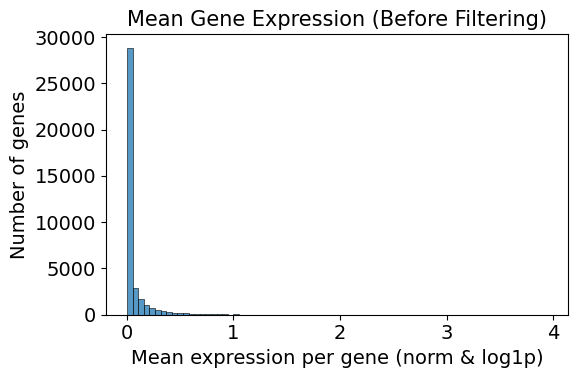

In [9]:
histogram_mean_norm_expression(adata_tf_ntc_unfiltered, title="Mean Gene Expression (Before Filtering)")

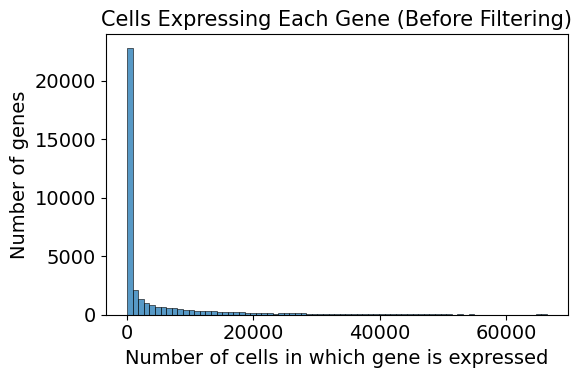

In [10]:
histogram_cells_expressing_gene(adata_tf_ntc_unfiltered, title="Cells Expressing Each Gene (Before Filtering)")

After filtering

In [11]:
adata_tf_ntc_30_100 = filter_low_expressed_genes(adata_tf_ntc, percent_threshold=30, min_n_cells=100)

normalizing counts per cell
    finished (0:00:00)
Removed 22241 genes


In [12]:
adata_tf_ntc_30_100

AnnData object with n_obs × n_vars = 66439 × 15326
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    uns: 'log1p'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'histogram'

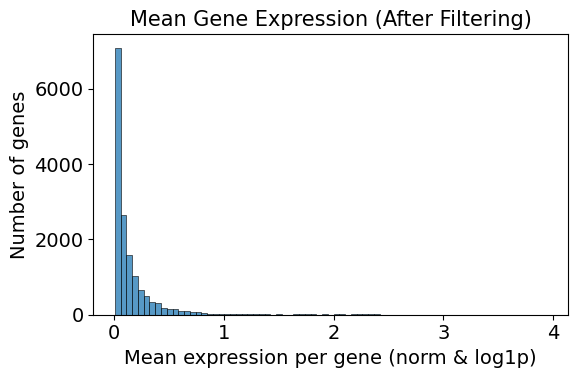

In [13]:
histogram_mean_norm_expression(adata_tf_ntc_30_100, title="Mean Gene Expression (After Filtering)")

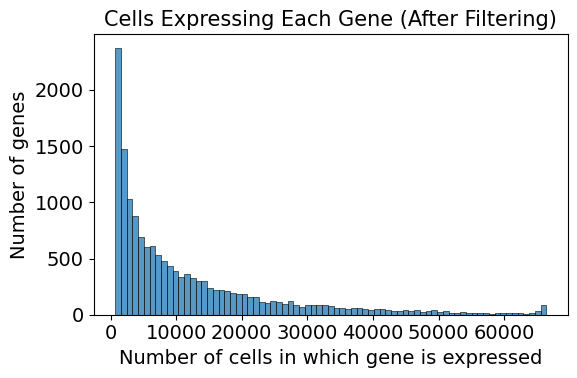

In [14]:
histogram_cells_expressing_gene(adata_tf_ntc_30_100, title="Cells Expressing Each Gene (After Filtering)")

In [15]:
filtered_genes = pd.DataFrame(adata_tf_ntc_30_100.var.index)
filtered_genes.head()

,0
0,ENSG00000241860
1,ENSG00000290385
2,ENSG00000291215
3,LINC01409
4,LINC00115


In [16]:
filtered_genes.to_pickle("/home/ranwyl/data_tf_project/genes_filtered_30pct_100cells.pkl")

# Step G: Differential expression analysis - partitioning method

We will carry out differential expression analysis with PyDESeq2 using a pseudobulk method. The cells for each KO are partitioned evenly into 2 pseudoreplicates and compared to an equal number of NTC cells.

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Genes that passed filtering out lowly expressed genes
genes_to_keep = pd.read_pickle("/home/ranwyl/data_tf_project/genes_filtered_30pct_100cells.pkl")
genes_to_keep = genes_to_keep[0].tolist()

In [3]:
def filter_tf_ko_and_ntc(adata):
    """
    Filter for TF KO and NTC cells.
    """
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def pre_DE_analysis(adata, genes_to_keep_list):
    """
    Prepare dataset for differential expression analysis using PyDESeq2.
    """
    # Filter TF KO and NTC cells
    adata = filter_tf_ko_and_ntc(adata)
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()
    # Remove lowly expressed genes
    adata = adata[:,adata.var.index.isin(genes_to_keep_list)].copy()
    return adata

In [4]:
def tf_generate_2_pseudoreplicates_for_DE(adata, gene_target, ntc_cells, rng):
    """
    Generate 2 pseudoreplicates for a given gene target and matched NTC cells.
    Manually set NTC as reference for differential expression analysis.
    rng = numpy Generator object
    """
    data_matrix = adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    # Create gene target pseudoreplicates
    rep_size = len(target_indices) // 2
    sample_size = rep_size * 2
    sampled_target_indices = rng.choice(target_indices, sample_size, replace=False)
    target_indices1 = sampled_target_indices[:rep_size]
    target_indices2 = sampled_target_indices[rep_size:]
    for rep_number, rep_indices in enumerate([target_indices1, target_indices2]):
        target_profile = data_matrix[rep_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{rep_number+1}")

    # Create NTC pseudoreplicates
    sampled_ntc_indices = rng.choice(ntc_cells, sample_size, replace=False)
    ntc_indices1 = sampled_ntc_indices[:rep_size]
    ntc_indices2 = sampled_ntc_indices[rep_size:]
    for rep_number, rep_indices in enumerate([ntc_indices1, ntc_indices2]):
        ntc_profile = data_matrix[rep_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{rep_number+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=16):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]", adapt=False) 
    results = stat_res.results_df
    return results


def tf_run_deseq2_analysis(adata, n_cpus=16, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                           alpha=0.05, de_rng=None):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group
    n_gene_targets = len(gene_targets)

    # Create RNG object to handle case where one is not provided
    if de_rng is None:
        hard_coded_seed = 12345
        de_rng = np.random.default_rng(hard_coded_seed)
    # Create one child RNG object per gene target
    streams = de_rng.spawn(n_gene_targets)

    # Function to run DE analysis on a single gene target
    def process_gene_target(gene_target, rng):
        pseudo_bulk_df, metadata_df = tf_generate_2_pseudoreplicates_for_DE(
            adata, gene_target, ntc_cells, rng=rng
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    # Run DE analysis on all gene targets in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(
            delayed(process_gene_target)(gene_target, rng) for gene_target, rng in zip(gene_targets, streams))
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_build_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

Batch ALPHA

In [13]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")

In [14]:
alpha_kos = adata_alpha.obs["gene_target"].unique().to_list()
print(f"Batch ALPHA has {len(alpha_kos) - 1} unique KOs")

Batch ALPHA has 1449 unique KOs


In [15]:
adata_alpha = pre_DE_analysis(adata_alpha, genes_to_keep)
adata_alpha

AnnData object with n_obs × n_vars = 44248 × 15326
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [16]:
alpha_tf_kos = adata_alpha.obs["gene_target"].unique().to_list()
print(f"Batch ALPHA has {len(alpha_tf_kos) - 1} unique TF KOs")

Batch ALPHA has 654 unique TF KOs


Batch BETA

In [5]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")

In [6]:
adata_beta

AnnData object with n_obs × n_vars = 75646 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [7]:
beta_kos = adata_beta.obs["gene_target"].unique().to_list()
print(f"Batch BETA has {len(beta_kos) - 1} unique KOs")

Batch BETA has 1390 unique KOs


In [8]:
adata_beta = pre_DE_analysis(adata_beta, genes_to_keep)
adata_beta

AnnData object with n_obs × n_vars = 12881 × 15326
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [9]:
beta_tf_kos = adata_beta.obs["gene_target"].unique().to_list()
print(f"Batch BETA has {len(beta_tf_kos) - 1} unique TF KOs")

Batch BETA has 3 unique TF KOs


In [12]:
print(f"Batch BETA TF KO and NTC gene targets: {', '.join(beta_tf_kos)}")

Batch BETA TF KO and NTC gene targets: NTC, SNAPC5, TRAFD1, ZBED6


In [13]:
results_dict_beta = tf_run_deseq2_analysis(adata_beta, n_cpus=25)

Running DE analysis:   0%|          | 0/3 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be p

In [14]:
beta_DE_df = tf_build_DE_df(results_dict_beta)

In [16]:
beta_DE_df.head()

,SNAPC5_baseMean,SNAPC5_log2FoldChange,SNAPC5_lfcSE,SNAPC5_stat,SNAPC5_pvalue,SNAPC5_padj,TRAFD1_baseMean,TRAFD1_log2FoldChange,TRAFD1_lfcSE,TRAFD1_stat,TRAFD1_pvalue,TRAFD1_padj,ZBED6_baseMean,ZBED6_log2FoldChange,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj
A1BG,2.664233,-0.120847,1.062761,-0.263113,0.792464,0.999245,2.460073,-0.019421,1.060802,-0.043839,0.965033,0.999758,0.485031,0.211798,2.337732,0.596442,0.550880,0.999801
A1BG-AS1,0.250000,0.177851,1.856653,0.344088,0.730780,0.999245,0.720945,0.083665,1.450443,0.281609,0.778243,0.999758,0.272599,-0.107936,1.109439,-0.299989,0.764186,0.999801
A2M,0.750000,0.249916,2.564296,0.757960,0.448475,0.999245,1.229904,0.080756,1.283800,0.213057,0.831282,0.999758,0.757630,0.095725,1.422993,0.310586,0.756116,0.999801
A2ML1,1.252396,-0.413068,1.183491,-0.959739,0.337187,0.999245,1.487640,-0.215394,1.133068,-0.517866,0.604551,0.999758,0.235031,0.096288,2.530186,0.259319,0.795389,0.999801
A2ML1-AS1,4.169808,-0.117856,1.023573,-0.249306,0.803124,0.999245,9.017974,0.203777,0.763491,0.397027,0.691348,0.999758,1.215485,-0.105367,1.169151,-0.270914,0.786457,0.999801


Batch GAMMA

In [17]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [18]:
adata_gamma

AnnData object with n_obs × n_vars = 47542 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [20]:
gamma_kos = adata_gamma.obs["gene_target"].unique().to_list()
print(f"Batch GAMMA has {len(gamma_kos) - 1} unique KOs")

Batch GAMMA has 975 unique KOs


In [21]:
adata_gamma = pre_DE_analysis(adata_gamma, genes_to_keep)
adata_gamma

AnnData object with n_obs × n_vars = 9310 × 15326
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'h

In [22]:
gamma_tf_kos = adata_gamma.obs["gene_target"].unique().to_list()
print(f"Batch GAMMA has {len(gamma_tf_kos) - 1} unique TF KOs")

Batch GAMMA has 3 unique TF KOs


In [23]:
print(f"Batch GAMMA TF KO and NTC gene targets: {', '.join(gamma_tf_kos)}")

Batch GAMMA TF KO and NTC gene targets: NTC, FAM200B, SGSM2, THYN1


In [24]:
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, n_cpus=25)

Running DE analysis:   0%|          | 0/3 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispers

In [25]:
gamma_DE_df = tf_build_DE_df(results_dict_gamma)

In [26]:
gamma_DE_df.head()

,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj,SGSM2_baseMean,SGSM2_log2FoldChange,SGSM2_lfcSE,SGSM2_stat,SGSM2_pvalue,SGSM2_padj,THYN1_baseMean,THYN1_log2FoldChange,THYN1_lfcSE,THYN1_stat,THYN1_pvalue,THYN1_padj
A1BG,1.251531,-0.265526,1.159137,-0.750844,0.452747,0.999519,2.765363,-0.268671,1.070311,-0.577962,0.563290,0.999536,2.003321,0.003235,1.140248,0.005565,0.995560,0.999947
A2M,1.258032,0.103756,1.302599,0.276521,0.782148,0.999519,0.250499,-0.166404,1.159955,-0.377359,0.705907,0.999536,0.983782,-0.005105,1.194165,-0.012767,0.989814,0.999947
A2ML1,0.976029,-0.428671,1.200308,-1.024659,0.305524,0.999519,0.225901,0.149452,1.993094,0.304533,0.760722,0.999536,0.677702,0.225171,2.678810,0.715041,0.474583,0.999947
A2ML1-AS1,5.661032,-0.291939,0.858346,-0.563451,0.573128,0.999519,1.702382,0.057556,1.158344,0.130601,0.896091,0.999536,4.440480,0.172508,1.132493,0.367670,0.713119,0.999947
AAAS,2.455846,0.164863,1.139076,0.355952,0.721876,0.999519,NaN,NaN,NaN,NaN,NaN,NaN,1.515762,-0.165311,1.152625,-0.429657,0.667445,0.999947


Combine all DE results into one DataFrame

In [ ]:
DE_results = pd.concat([alpha_DE_df, beta_DE_df, gamma_DE_df], axis=1)
DE_results = aggregate_DE_df.sort_index()
DE_results.head()

Write out results

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_09-2025.pkl"
DE_results.to_pickle(filepath_pkl)

Rename genes that are listed by Ensembl ID but have a gene name

all_genes = de_results.index.tolist()
ensg_genes = [g for g in all_genes if g.startswith("ENSG")]
print(len(ensg_genes))
print(ensg_genes[:5])

In [ ]:
mg = get_client('gene')
ensembl_results_all = mg.querymany(ensg_genes, fields='symbol', species='human')

Manually search for the genes with duplicate hits on GeneCards. To break ties, use the highest GeneCards Inferred Functionality Score (GIFtS). If there is a tie between highest scoring gene symbols, keep the gene as its Ensembl ID.

In [ ]:
# Change this
dup_hits = {'ENSG00000234352': 'LOC349160', 'ENSG00000249738':'IL12B-AS1', 'ENSG00000257545':'LOC100287944'}

Rename genes

In [ ]:
ensembl_to_gene = dict()
for r in ensembl_results_all:
  if r.get('symbol'):
      ensembl_to_gene[r.get('query')] = r.get('symbol')
ensembl_to_gene.update(dup_hits) # Change duplicate hits
print(len(ensembl_to_gene))

In [ ]:
def rename_ensembl_genes(de_df, ensembl_to_gene_dict):
    """
    Rename genes in DataFrame.
    """
    de_df_renamed = de_df.rename(index=ensembl_to_gene_dict)
    print(f"Converted {len(ensembl_to_gene_dict)} Ensembl IDs to gene symbols")
    return de_df_renamed

In [ ]:
DE_results_renamed = rename_ensembl_genes(DE_results, ensembl_to_gene)

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_names_09-2025.pkl"
DE_results_renamed.to_pickle(filepath_pkl)

# Step H: Batch Correction

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [ ]:
# Filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

# Remove lowly expressed genes based on list
def filter_low_expr_genes(adata, genes_to_keep_list):
    return adata[:,adata.var.index.isin(genes_to_keep_list)].copy()

def filter_cells_and_genes(adata, genes_to_keep_list):
    adata = filter_tf_ko_and_ntc(adata)
    return filter_low_expr_genes(adata, genes_to_keep_list)

# Genes that passed filtering out lowly expressed genes
genes_to_keep = pd.read_pickle("/home/ranwyl/data_tf_project/genes_filtered_30pct_100cells.pkl")
genes_to_keep = genes_to_keep[0].tolist()

In [ ]:
adata_alpha_filtered = filter_cells_and_genes(adata_alpha, genes_to_keep)
adata_beta_filtered = filter_cells_and_genes(adata_beta, genes_to_keep)
adata_gamma_filtered = filter_cells_and_genes(adata_gamma, genes_to_keep)

In [ ]:
adata_combined = ad.concat([adata_alpha_filtered, adata_beta_filtered, adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()
adata_combined

Normalizate to median UMI count of all NTC cells

In [ ]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)

Perform log1p transformation and batch correction

In [ ]:
sc.pp.log1p(adata_combined)

# Batch correction via relative z-normalization
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()
qc2.relative_z_normalization(a)
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)

normalized_adata = ad.concat([a,b,c])
normalized_adata

In [ ]:
normalized_adata.write("/home/ranwyl/data_tf_project/Final_Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")